# Layered Model - Result Comparison

### For the model, see the notebook `BlockModel-Create.ipynb`.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Helper routines

In [3]:
def extract_lines(name):
    """Get data <name>."""
    inp = xr.load_dataset(name, engine='h5netcdf')
    print_attributes(inp)
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out


def print_attributes(inp):
    """Print info from modeller."""
    for key in ['runtime', 'n_procs', 'max_ram',
                'n_cells', 'n_nodes', 'n_dof', 'extent',
                'min_vol', 'max_vol', 'machine',
                'version', 'date']:
        print(f"{key:10} : {inp.attrs[key]}")


def get_amp_pha(resp, off, min_off, ampha):
    """Return amplitude or phase."""
    
    if ampha == 0:
        resp = abs(resp)
    else:
        resp = np.unwrap(np.angle(np.nan_to_num(resp.conj())))*180/np.pi

    resp[off < min_offset] = np.nan

    return resp

## Load info and data

### Survey info

In [4]:
ds = xr.load_dataset('block_model_and_survey.nc', engine='h5netcdf')
rec_x = ds.x[::2].data
rec_y = ds.attrs['rec_y']

### Load data, compute relative error

In [5]:
data = {
    'empymod': 'empymod',
    'emg3d': 'emg3d',
    'custEM': 'custEM_p2',
    'PETGEM': 'petgem',
    'SimPEG': 'simpeg',
}

# Load all data
for key, value in data.items():
    print(f"\n= {key} =\n-----------")
    data[key] = extract_lines(f"results/layered_{value}.nc")


= empymod =
-----------
runtime    : 0 s
n_procs    : 1
max_ram    : 0.004 GiB
n_cells    : N/A
n_nodes    : N/A
n_dof      : N/A
extent     : N/A
min_vol    : N/A
max_vol    : N/A
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 20.04
version    : empymod v2.0.4
date       : 2021-01-28T09:18:13.241308

= emg3d =
-----------
runtime    : 216 s
n_procs    : 1
max_ram    : 0.532 GiB
n_cells    : (256 x 80 x 96) - 1966080
n_nodes    : N/A
n_dof      : 6004144
extent     : x = -55672.5-65474.2; y = -51087.5-51087.5; z = -35514.7-65482.0
min_vol    : 31250.0
max_vol    : 2478442600555.7
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 20.04
version    : emg3d v0.16.0
date       : 2021-01-29T19:21:03.783825

= custEM =
-----------
runtime    : 232 s
n_procs    : 48
max_ram    : 244.1 GiB
n_cells    : 932319
n_nodes    : 152665
n_dof      : 11799156
extent     : x = -100000 - 100000; y = -100000 - 100000; z = -100000 - 100000
min_vol    : 12500

## Comparison Plots

In [6]:
# We plot data at offsets < min_offset
min_offset = 500

# Markers for scatter plots
marker = ['s', 'v', '^', 'o']
ms = [3.5, 4.5, 4.5, 4]

# Properties we loop over or use in loops
reim = [np.real, np.imag, np.abs]
lines = ["Inline", "Broadside"]
color = ['k', '0.6']

<IPython.core.display.Javascript object>


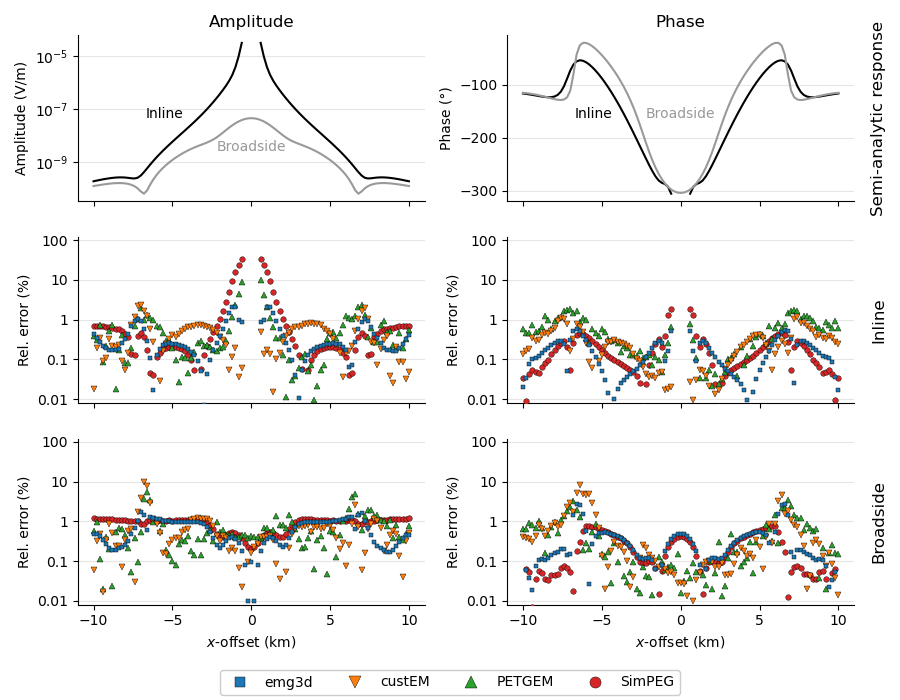

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(9, 7), sharex=True)
((ax1, ax2), (ax3, ax4), (ax5, ax6)) = axs


# # (A) Plot semi-analytical responses # #

# Plot over amplitude, phase
for i, ax in enumerate(axs[0, :]):
    
    # Title
    ax.set_title(['Amplitude', 'Phase'][i])
    
    # Loop over inline, broadside
    for iy, line in enumerate(lines):
        
        # Get offset
        off = np.sqrt(rec_x**2 + rec_y[iy+1]**2)
    
        # Plot them
        resp = get_amp_pha(data['empymod'][:, iy+1], off, min_offset, i)
        ax.plot(rec_x/1e3, resp, '-', c=color[iy], label=line)
        
        ax.text(np.array([[0.25, 0.5], [0.25, 0.5]])[i, iy],
                np.array([[0.5, 0.3], [0.5, 0.5]])[i, iy],
                lines[iy], c=color[iy], horizontalalignment='center',
                transform=ax.transAxes)

    # Axis labeling, scaling, etc
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.grid(axis='y', c='0.9')
    
    if i == 0:
        ax.set_yscale('log')
        ax.set_ylabel("Amplitude (V/m)")
    else:
        ax.set_ylabel("Phase (°)")
        ax.text(1.05, 0.5, 'Semi-analytic response', rotation=90,
                verticalalignment='center', transform=ax.transAxes,
                fontsize=12)

        
# # (B) Plot relative error # #

# Plot over ({Amplitude;Phase}-{inline;broadside})
for i, ax in enumerate(axs[1:, :].ravel()):
           
    # Loop over codes
    for ii, name in enumerate(list(data)[1:]):
       
        # Get offset
        off = np.sqrt(rec_x**2 + rec_y[i // 2 + 1]**2)
        
        # Compute error
        epm = get_amp_pha(data['empymod'][:, i // 2 + 1], off, min_offset, i%2)
        code = get_amp_pha(data[name][:, i // 2 + 1], off, min_offset, i%2)
        error = 100*abs((code-epm)/epm)        
  
        ax.plot(rec_x/1e3, error, f'C{ii}{marker[ii]}',
                mec='k', mew=0.3,
                #mfc='none',
                ms=ms[ii], label=name, zorder=10-ii)

    # Axis labeling, scaling, etc
    ax.set_yscale('log')
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.set_ylim([8e-3, 120])
    ax.set_yticks([0.01, 0.1, 1, 10, 100])
    ax.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
    ax.grid(axis='y', c='0.9')
    if i in [1, 3]:
        ax.text(1.05, 0.5, lines[i//2], rotation=90,
                verticalalignment='center', transform=ax.transAxes,
                fontsize=12)
    ax.set_ylabel('Rel. error (%)')
    if i > 1:
        ax.set_xlabel('$x$-offset (km)')

# Switch off spines
for ax in axs.ravel():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout(rect=[0, 0.05, 1, 1])

# Legends
#ax2.legend(bbox_to_anchor=(0.5, 0.05), loc='center', framealpha=1)
ax6.legend(bbox_to_anchor=(0.5, 0.025), bbox_transform=fig.transFigure,
           loc='center', framealpha=1, ncol=4, markerscale=2)

fig.savefig(f'../manuscript/figures/results-layered.pdf', bbox_inches='tight')
fig.savefig(f'../manuscript/figures/results-layered.png', bbox_inches='tight', dpi=300)
fig.show()

In [8]:
import scooby
scooby.Report()

--------------------------------------------------------------------------------
  Date: Fri Jan 29 19:34:18 2021 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:38)
  [GCC 7.3.0]

             numpy : 1.19.5
             scipy : 1.6.0
           IPython : 7.19.0
        matplotlib : 3.3.3
            scooby : 0.5.6

  Intel(R) Math Kernel Library Version 2020.0.4 Product Build 20200917 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------